In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import stats
import math

data = pd.read_csv('/content/drive/MyDrive/Datasets/hotel_guests_dataset.csv')
data.head()

,Unnamed: 0,guest_email,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,0,dsullivan@example.net,False,BASIC,8.324971,04 Apr 2020,23 Apr 2020,146.834507,"90469 Karla Knolls Apt. 781\nSusanberg, NC 28401",5161033759518983
1,1,steven59@example.org,False,BASIC,NaN,27 Jun 2020,16 Aug 2020,185.497813,"1080 Ashley Creek Apt. 622\nWest Amy, NM 25058",4133047413145475690
2,2,brandon15@example.net,False,BASIC,22.269158,13 Apr 2020,07 Apr 2020,151.115528,"99923 Anderson Trace Suite 861\nNorth Haley, T...",4977328103788
3,3,humphreyjennifer@example.net,False,BASIC,25.468647,22 May 2020,08 Jun 2020,182.468031,"9301 John Parkways\nThomasland, OH 61350",3524946844839485
4,4,joshuabrown@example.net,False,BASIC,19.778311,14 Nov 2019,27 Oct 2019,195.497743,"126 George Tunnel\nDuranstad, MS 95176",4446905799576890978


In [2]:
data.describe()

,Unnamed: 0,amenities_fee,room_rate,credit_card_number
count,2000.000000,1816.000000,2000.000000,2.000000e+03
mean,999.500000,18.625723,156.397620,3.529920e+17
std,577.494589,9.900830,50.793336,1.212466e+18
min,0.000000,0.000000,83.800000,6.040371e+10
25%,499.750000,11.897006,115.704236,3.674461e+13
50%,999.500000,18.334560,153.181718,3.514294e+15
75%,1499.250000,25.566208,192.001124,4.583879e+15
max,1999.000000,47.478848,345.459749,4.984532e+18


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          2000 non-null   int64  
 1   guest_email         2000 non-null   object 
 2   has_rewards         2000 non-null   bool   
 3   room_type           2000 non-null   object 
 4   amenities_fee       1816 non-null   float64
 5   checkin_date        2000 non-null   object 
 6   checkout_date       1931 non-null   object 
 7   room_rate           2000 non-null   float64
 8   billing_address     2000 non-null   object 
 9   credit_card_number  2000 non-null   int64  
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 142.7+ KB


In [ ]:
# Data Hilang
amefee_mean = data['amenities_fee'].mean()
data['amenities_fee'].fillna(amefee_mean, inplace=True)

data['checkin_date'] = pd.to_datetime(data['checkin_date'])
data['checkout_date'] = pd.to_datetime(data['checkout_date'])
stay = (data['checkout_date'] - data['checkin_date']).dt.days
stay_mean = stay.mean()
checkout_new = data['checkin_date'] + pd.to_timedelta(stay_mean, unit='D')
data['checkout_date'].fillna(checkout_new, inplace=True)

In [5]:
def extract_address_details(address):
    split1 = address.split(' ', 1)
    angka_awal = split1[0]
    try:
        alamat_lengkap, sisa = split1[1].split('\n')
        kota_kode = sisa.split(', ')
        if len(kota_kode) >= 2:
            kode_kota = kota_kode[1].split()[0]
            kode_akhir = kota_kode[1].split()[1]
        else:
            kode_kota = None
            kode_akhir = None
    except IndexError:
        alamat_lengkap = None
        kode_kota = None
        kode_akhir = None
    return pd.Series([angka_awal, alamat_lengkap, kode_kota, kode_akhir])

data_extracted = data['billing_address'].apply(extract_address_details)
data_extracted.columns = ['kode_alamat', 'alamat_lengkap', 'kode_kota', 'kode_wilayah']
data = pd.concat([data, data_extracted], axis=1)

coloumn_target = "credit_card_number"
other_column = [col for col in data.columns if col != coloumn_target]
new_order = other_column + [coloumn_target]
data = data[new_order]

data.head()

,Unnamed: 0,guest_email,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,kode_alamat,alamat_lengkap,kode_kota,kode_wilayah,credit_card_number
0,0,dsullivan@example.net,False,BASIC,8.324971,2020-04-04,2020-04-23,146.834507,"90469 Karla Knolls Apt. 781\nSusanberg, NC 28401",90469,Karla Knolls Apt. 781,NC,28401,5161033759518983
1,1,steven59@example.org,False,BASIC,18.625723,2020-06-27,2020-08-16,185.497813,"1080 Ashley Creek Apt. 622\nWest Amy, NM 25058",1080,Ashley Creek Apt. 622,NM,25058,4133047413145475690
2,2,brandon15@example.net,False,BASIC,22.269158,2020-04-13,2020-04-07,151.115528,"99923 Anderson Trace Suite 861\nNorth Haley, T...",99923,Anderson Trace Suite 861,TX,76565,4977328103788
3,3,humphreyjennifer@example.net,False,BASIC,25.468647,2020-05-22,2020-06-08,182.468031,"9301 John Parkways\nThomasland, OH 61350",9301,John Parkways,OH,61350,3524946844839485
4,4,joshuabrown@example.net,False,BASIC,19.778311,2019-11-14,2019-10-27,195.497743,"126 George Tunnel\nDuranstad, MS 95176",126,George Tunnel,MS,95176,4446905799576890978


In [6]:
data['checkin_date'] = pd.to_datetime(data['checkin_date'])
data['pendapatan'] = data['room_rate'] + data['amenities_fee']

data['year_month'] = data['checkin_date'].dt.to_period('M')
pendapatan_bulanan = data.groupby('year_month')['pendapatan'].mean().apply(math.ceil)
print("Rata-rata Pendapatan Bulanan:")
pendapatan_bulanan

Rata-rata Pendapatan Bulanan:


,pendapatan
year_month,
2019-06,122
2019-08,185
2019-09,163
2019-10,187
2019-11,164
2019-12,162
2020-01,181
2020-02,171
2020-03,178


#Keterangan
Hal tersebut menunjukkan rata-rata pendapatan dari hotel berdasarkan bulan.

In [7]:
data['checkin_date'] = pd.to_datetime(data['checkin_date'])
data['pendapatan'] = data['room_rate'] + data['amenities_fee']

data['year'] = data['checkin_date'].dt.to_period('Y')
pendapatan_bulanan = data.groupby('year')['pendapatan'].mean()
print("Rata-rata Pendapatan Tahunan:")
pendapatan_bulanan

Rata-rata Pendapatan Tahunan:


,pendapatan
year,
2019,167.242552
2020,175.131982
2021,179.151660


#Keterangan
Hal tersebut menunjukkan rata-rata pendapatan dari hotel berdasarkan tahun.

#Visualisasi

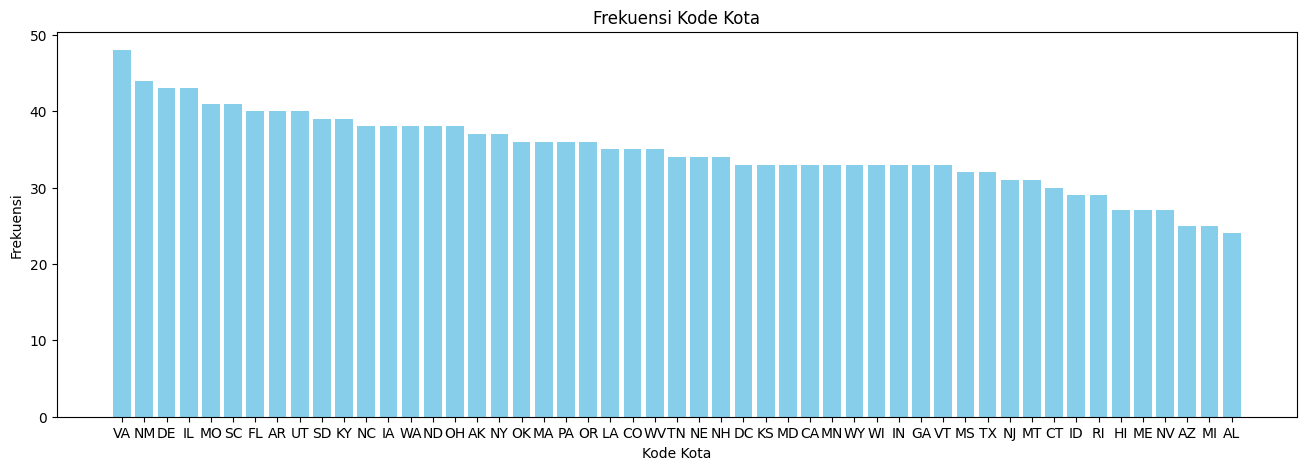

In [8]:
plt.figure(figsize=(16, 5))
kode_kota_counts = data['kode_kota'].value_counts()
plt.bar(kode_kota_counts.index, kode_kota_counts.values, color='skyblue')
plt.title('Frekuensi Kode Kota')
plt.xlabel('Kode Kota')
plt.ylabel('Frekuensi')
plt.show()

#Keterangan
Diagram tersebut menunjukkan jumlah frekuesi dari pemesan kamar berdasarkan kode kota yang ada di alamat mereka.

['NC' 'NM' 'TX' 'OH' 'MS' 'AR' 'MD' 'NE' 'AZ' 'WI' 'DE' 'GA' 'CO' 'UT'
 'SD' 'MN' None 'DC' 'MA' 'WV' 'IN' 'MT' 'TN' 'IL' 'MI' 'ME' 'AK' 'VA'
 'NJ' 'SC' 'RI' 'WA' 'HI' 'WY' 'VT' 'NH' 'CA' 'MO' 'PA' 'KS' 'CT' 'OR'
 'ID' 'NV' 'OK' 'AL' 'IA' 'LA' 'FL' 'KY' 'NY' 'ND']

Masukkan kode kota yang ingin dilihat: KY


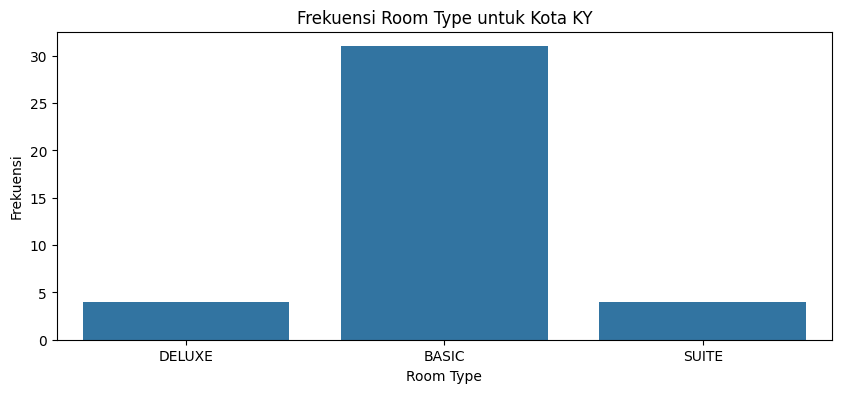

In [9]:
print(data['kode_kota'].unique())
kode_kota = input("\nMasukkan kode kota yang ingin dilihat: ")
data_kota = data[data['kode_kota'] == kode_kota]
if not data_kota.empty:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=data_kota, x='room_type')

    plt.title(f'Frekuensi Room Type untuk Kota {kode_kota}')
    plt.xlabel('Room Type')
    plt.ylabel('Frekuensi')
    plt.show()
else:
    print(f"Tidak ada data untuk kode kota: {kode_kota}")

#Keterangan
Bar chart ini menunjukkan perbandinigan antara banyak jumlah ruangan yang dipesan di setiap kode kota.

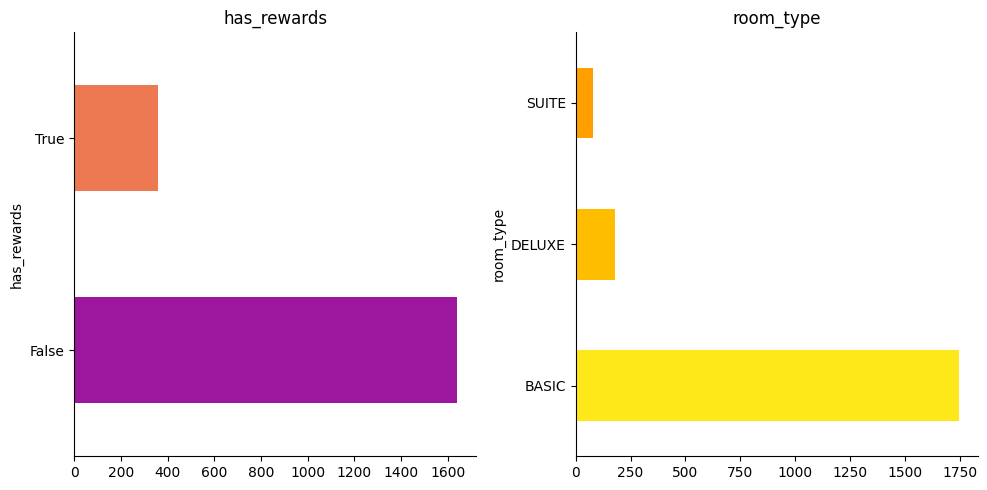

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# has_rewards
data.groupby('has_rewards').size().plot(kind='barh', color=sns.color_palette('plasma', len(data['has_rewards'].unique())), ax=axs[0])
axs[0].set_title('has_rewards')
axs[0].spines[['top', 'right']].set_visible(False)

# room_type
data.groupby('room_type').size().plot(kind='barh', color=sns.color_palette('Wistia', len(data['room_type'].unique())), ax=axs[1])
axs[1].set_title('room_type')
axs[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

#Keterangan
Bar chart ini menunjukkan perbandinigan antara jumlah ruangan yang dipesan dengan reward yang mereka dapatkan.

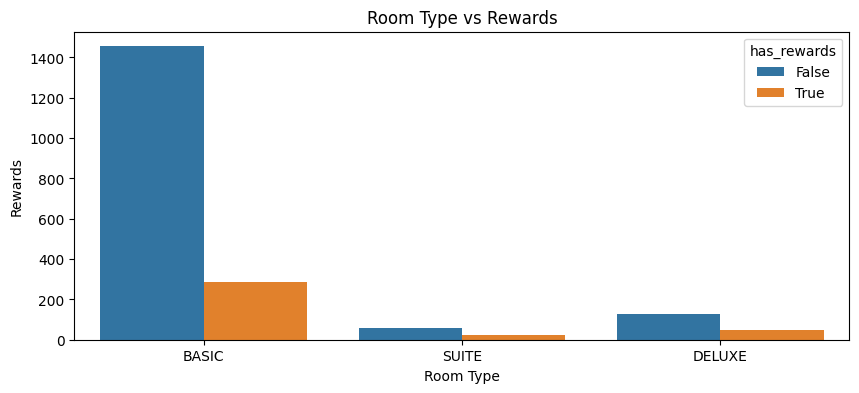

In [11]:
plt.figure(figsize=(10, 4))
sns.countplot(x="room_type", hue="has_rewards", data=data)
plt.title('Room Type vs Rewards')
plt.xlabel('Room Type')
plt.ylabel('Rewards')
plt.show()

#Keterangan
Bar chart ini menunjukkan perbandinigan antara jumlah ruangan yang dipesan dengan reward yang mereka dapatkan.

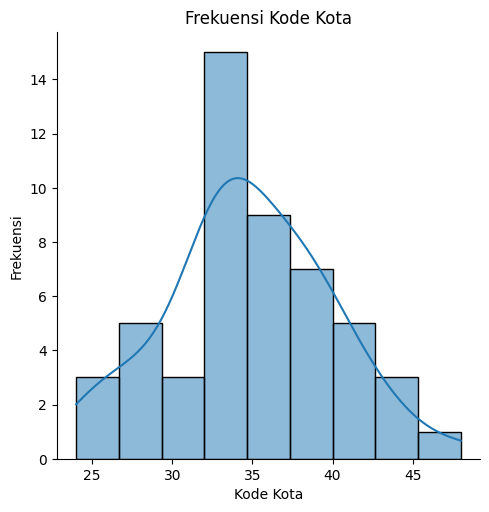

In [27]:
sns.displot(kode_kota_counts, kde="hist")
plt.title('Frekuensi Kode Kota')
plt.xlabel('Kode Kota')
plt.ylabel('Frekuensi')
plt.show()

#Keterangan
Histogram ini menunjukkan distribusi data dari Frekuensi pengunjung berasarkan kode kota yang ada.

In [14]:
tes = kode_kota_counts.max() / kode_kota_counts.sum()
tes

0.02708803611738149

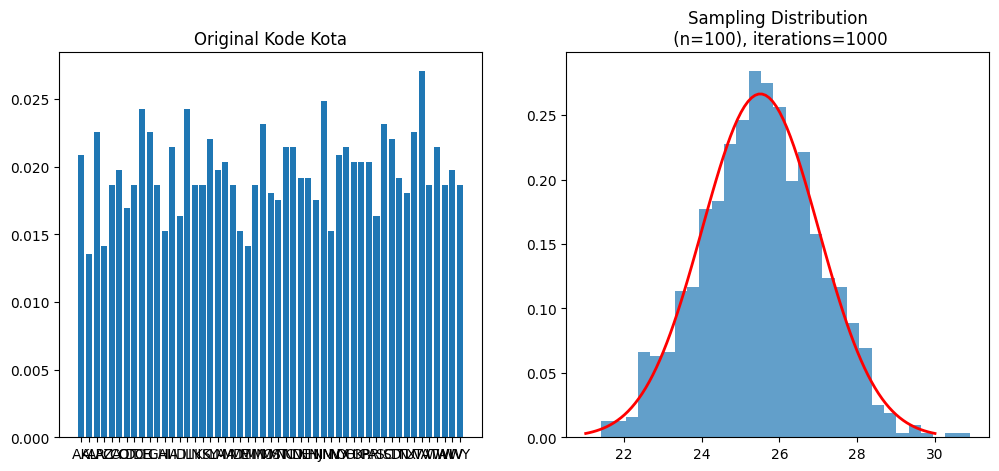

In [15]:
def demonstrate_clt(clt_kota, sample_size, num_interations):
  faces, probs = zip(*sorted(clt_kota.items()))

  faces_numeric = np.arange(len(faces))

  probs = np.array(probs) / sum(probs)
  sample_means = [np.random.choice(faces_numeric, size=sample_size, p=probs).mean()
                  for _ in range(num_interations)]
  fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
  ax1.bar(faces,probs)
  ax1.set_title("Original Kode Kota")
  ax2.hist(sample_means, bins=30, density=True, alpha=0.7)
  ax2.set_title(f'Sampling Distribution\n (n={sample_size}), iterations={num_interations}')

  mu, std = np.mean(sample_means), np.std(sample_means)
  x = np.linspace(mu - 3*std, mu + 3*std, 100)
  ax2.plot(x, stats.norm.pdf(x, mu, std), 'r-', linewidth=2)
  plt.show()

clt_kota = kode_kota_counts

demonstrate_clt(clt_kota, sample_size=100, num_interations=1000)

#Keterangan
Data tersebut menunjukkan proses normalisasi data dengan metode `Central Limit Theorem`. Hal ini membuat data berdistribusi lebih normal dengan menampilkan hasil hasil bagi dari np.array yang dibagi dengan probs nya.

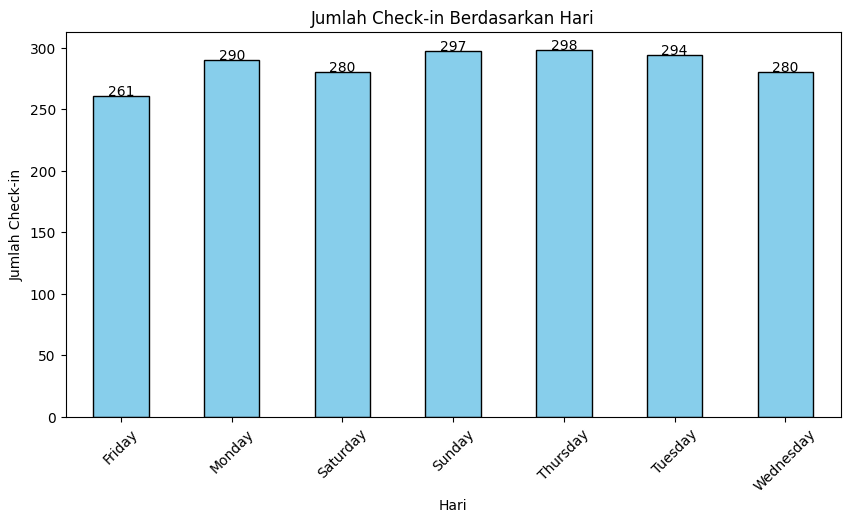

In [23]:
data['day_of_week'] = data['checkin_date'].dt.day_name()
day_counts = data['day_of_week'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
day_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Jumlah Check-in Berdasarkan Hari')
plt.xlabel('Hari')
plt.ylabel('Jumlah Check-in')
plt.xticks(rotation=45)
for i, value in enumerate(day_counts):
    plt.text(i, value + 0.5, str(value), ha='center')
plt.show()

#Keterangan:
Jika dilihat berdasarkan hari, maka hari yang paling banyak terjadi check-in pengunjung adalah hari Kamis, Minggu, Rabu, dan Senin. Oleh karena itu, kita bisa menganalisis lebih lanjut apa yang menyebabkan hari-hari tersebut memiliki banyak pengunjung.

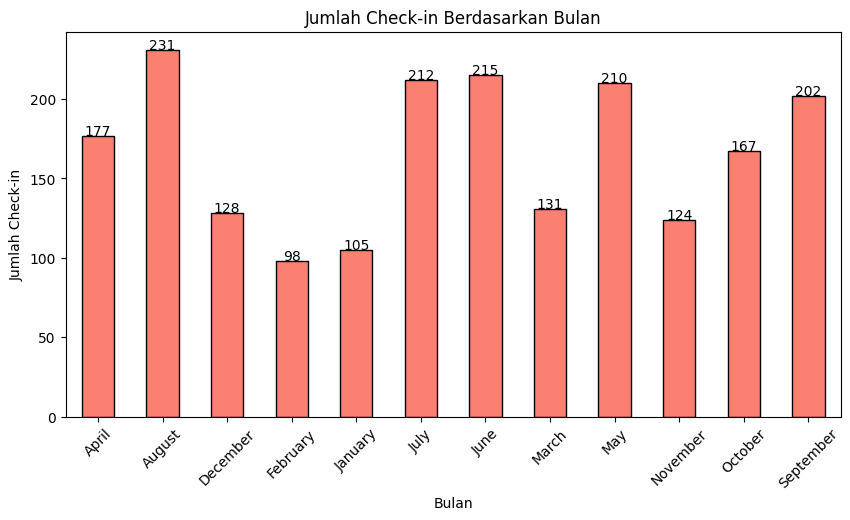

In [25]:
data['month'] = data['checkin_date'].dt.month_name()
month_counts = data['month'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
month_counts.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Jumlah Check-in Berdasarkan Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Check-in')
plt.xticks(rotation=45)
for i, value in enumerate(month_counts):
    plt.text(i, value + 0.5, str(value), ha='center')
plt.show()

#Keterangan:
Data tersebut menunjjukan bahwa banyak dari pengunjung yang menginap di hotel pada bulan mei, juni, july, dan agustus. Hal tersebut menunjukkan bahwa antara bulan tersebut bisa saja menjadi bulan liburan bagi suatu negara dan menjadikkannya bulan yang paling tepat untuk menginap di hotel.

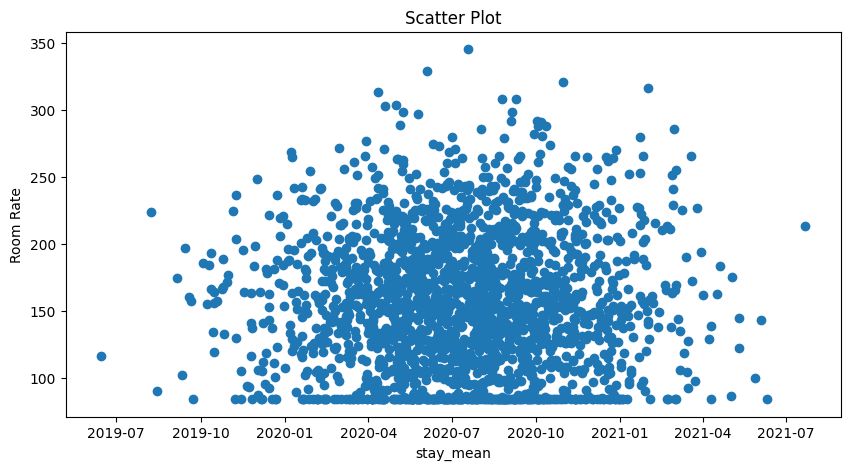

In [16]:
plt.figure(figsize=(10, 5))
plt.scatter(checkout_new, data["room_rate"])
plt.xlabel('stay_mean')
plt.ylabel('Room Rate')
plt.title('Scatter Plot')
plt.show()

#Keterangan
Scatter Plot tersebut menunjukkan bahwa tidak ada hubungan yang jelas antara harga ruangan dengan rata-rata tinggal pengunjung pada hotel.

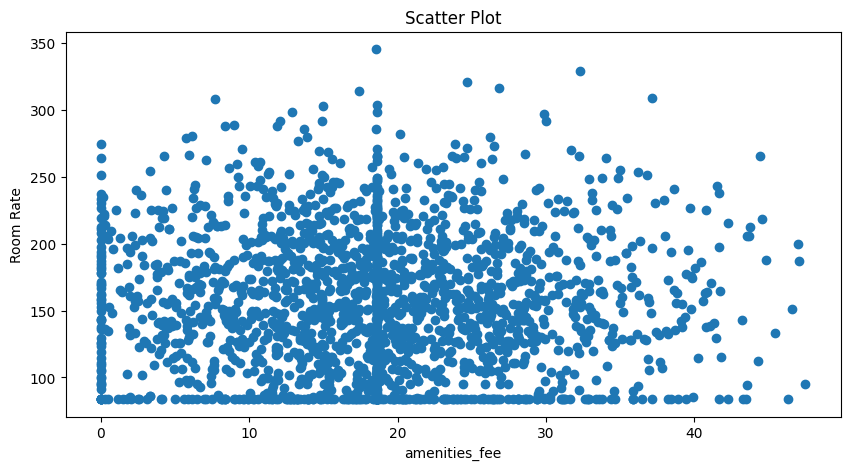

In [17]:
plt.figure(figsize=(10, 5))
plt.scatter(data['amenities_fee'], data["room_rate"])
plt.xlabel('amenities_fee')
plt.ylabel('Room Rate')
plt.title('Scatter Plot')
plt.show()

#Keterangan:
Scatter Plot tersebut menujukkan bahwa tidak ada hubungan yang signifikan antara harga ruangan dengan biaya tambahan dari ruangan tersebut.

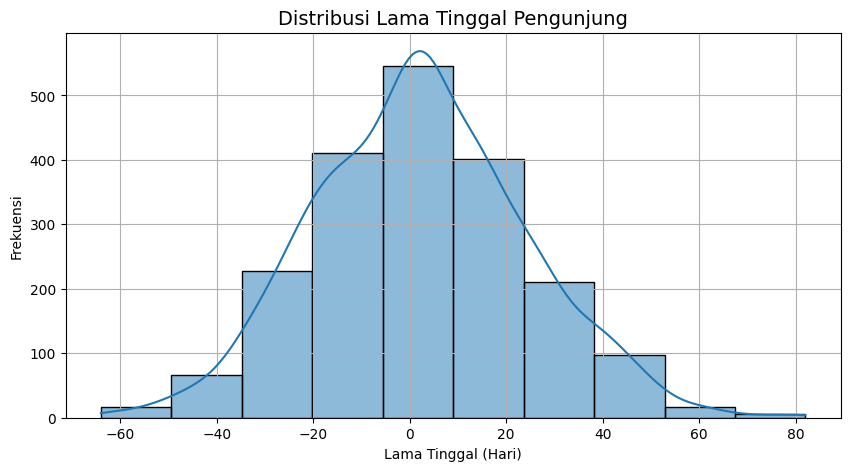

In [18]:
plt.figure(figsize=(10, 5))
stay = (data['checkout_date'] - data['checkin_date']).dt.days
sns.histplot(stay, bins=10, kde=True)
plt.title('Distribusi Lama Tinggal Pengunjung', fontsize=14)
plt.xlabel('Lama Tinggal (Hari)')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

#Keterangan:
Data tersebut menujukkan histogram dari distribusi data terkait "lama tinggal pengunjung" pada dataset yang menunjukkan bahwa banyak dari pengunjung yang minimal tinggal 1 malam hingga dibawah 10 malam